<a href="https://colab.research.google.com/github/nicoyogis/TUBES-ML/blob/main/TA_Maize_purposed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import json
import os  # Create directories, list files
import zipfile
import shutil
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mping
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization 
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import time

In [3]:
!pip install split_folders
import splitfolders

In [4]:
input_folder="/content/drive/MyDrive/projek/dataset" 
base_dir="/content/drive/MyDrive/projek/dataset_split"

In [5]:
splitfolders.ratio(input= input_folder, output= base_dir, seed=1337, ratio=(0.8, 0.2))

Copying files: 2000 files [09:09,  3.64 files/s]


In [6]:
Train = "/content/drive/MyDrive/projek/dataset_split/train"
Val = "/content/drive/MyDrive/projek/dataset_split/val"

In [7]:
file_train_cercospora = os.listdir(Train + "/cercospora")
file_train_commonrust = os.listdir(Train + "/commonrust")
file_train_normal = os.listdir(Train + "/normal")
file_train_northernleaf = os.listdir(Train + "/northernleaf")

file_val_cercospora   = os.listdir(Val + "/cercospora")
file_val_commonrust   = os.listdir(Val + "/commonrust")
file_val_normal       = os.listdir(Val + "/normal")
file_val_northernleaf = os.listdir(Val + "/northernleaf")


print("total training cercospora images    : " + str(len(file_train_cercospora)))
print("total training commonrust images    : " + str(len(file_train_commonrust)))
print("total training normal images        : " + str(len(file_train_normal)))
print("total training northernleaf images  : " + str(len(file_train_northernleaf)))

print("total val cercospora images    : " + str(len(file_val_cercospora)))
print("total val commonrust images    : " + str(len(file_val_commonrust)))
print("total val normal images        : " + str(len(file_val_normal)))
print("total val northernleaf images  : " + str(len(file_val_northernleaf)))


total training cercospora images    : 400
total training commonrust images    : 400
total training normal images        : 400
total training northernleaf images  : 400
total val cercospora images    : 100
total val commonrust images    : 100
total val normal images        : 100
total val northernleaf images  : 100


In [8]:
# define generator
from keras.preprocessing.image import ImageDataGenerator
train_gen = ImageDataGenerator(
    # featurewise_center=True,
    # featurewise_std_normalization=True,
    
    rotation_range=20,
    zoom_range=0.10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode = 'nearest',
    rescale = 1./255
    
)

val_gen = ImageDataGenerator(rescale = 1./255)

In [9]:
batch_size = 32

In [10]:

train_generator = train_gen.flow_from_directory(
    Train,
    target_size=(150, 150),
    class_mode='categorical',
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size
)

validation_generator = val_gen.flow_from_directory(
    Val,
    target_size=(150,150),
    class_mode='categorical',
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size
)

Found 1600 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [11]:
train_generator.class_indices

{'cercospora': 0, 'commonrust': 1, 'normal': 2, 'northernleaf': 3}

In [12]:
validation_generator.class_indices

{'cercospora': 0, 'commonrust': 1, 'normal': 2, 'northernleaf': 3}

In [13]:
# Feature Extraction Layer
model = Sequential()

model.add(InputLayer(input_shape=[150,150,3]))

model.add(Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Dropout(0.2))

In [14]:
model.add(Flatten())

In [15]:
# Fully Connected Layer
model.add(Dense(256, activation='relu')) #hidden
model.add(Dropout(0.3))
model.add(Dense(4, activation='softmax'))

In [16]:
# Print model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 75, 75, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 32)       1

In [17]:
# Compile model 1
model.compile(optimizer= Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [18]:
H = model.fit(train_generator, epochs=100, validation_data = validation_generator)

Epoch 1/100
50/50 [==============================] - 65s 1s/step - loss: 0.8206 - accuracy: 0.7156 - val_loss: 2.4673 - val_accuracy: 0.2500
Epoch 2/100
50/50 [==============================] - 64s 1s/step - loss: 0.4563 - accuracy: 0.8131 - val_loss: 3.7665 - val_accuracy: 0.2500
Epoch 3/100
50/50 [==============================] - 63s 1s/step - loss: 0.3887 - accuracy: 0.8244 - val_loss: 5.5092 - val_accuracy: 0.2500
Epoch 4/100
50/50 [==============================] - 63s 1s/step - loss: 0.3367 - accuracy: 0.8431 - val_loss: 5.5921 - val_accuracy: 0.2500
Epoch 5/100
50/50 [==============================] - 63s 1s/step - loss: 0.3338 - accuracy: 0.8544 - val_loss: 5.2462 - val_accuracy: 0.2900
Epoch 6/100
50/50 [==============================] - 63s 1s/step - loss: 0.2888 - accuracy: 0.8694 - val_loss: 5.4976 - val_accuracy: 0.2925
Epoch 7/100
50/50 [==============================] - 63s 1s/step - loss: 0.2985 - accuracy: 0.8694 - val_loss: 4.7695 - val_accuracy: 0.2975
Epoch 8/100
5

In [19]:
from keras.models import model_from_json
import json

target_dir = '/content/drive/MyDrive/projek/model'

# simpan history model kedua
history_dict = H.history
json.dump(history_dict, open(target_dir + '/history_MAIZE_1.json', 'w'))

# simpan model kedua dan weight-nya
model.save(target_dir + '/model_MAIZE_1.h5')
model.save_weights(target_dir + '/model_weights_MAIZE_1.h5')

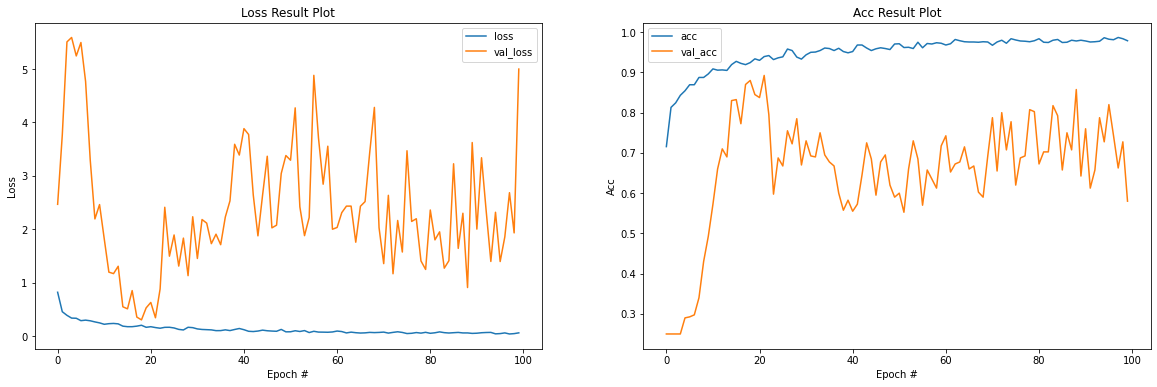

In [31]:
#plot model 1
fig, (plt1, plt2) = plt.subplots(1,2, figsize=(20,6)) #buat bikin subplot

plt1.figsize=(10,8)
plt1.plot(np.arange(0, 100), H.history["loss"], label="loss")
plt1.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
plt1.set_title("Loss Result Plot")
plt1.set_xlabel("Epoch #")
plt1.set_ylabel("Loss")
plt1.legend()

plt2.figsize=(10,8)
plt2.plot(np.arange(0, 100), H.history["accuracy"], label="acc")
plt2.plot(np.arange(0, 100), H.history["val_accuracy"], label="val_acc")
plt2.set_title("Acc Result Plot")
plt2.set_xlabel("Epoch #")
plt2.set_ylabel("Acc")
plt2.legend()

fig.savefig('myimage.svg', format='svg', dpi=1200)

In [32]:
#Evaluasi menggunakan classification report
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import files

ypred = model.predict(validation_generator)
prediction = np.argmax(ypred, axis=1)
print(classification_report(validation_generator.classes, prediction))

              precision    recall  f1-score   support

           0       1.00      0.11      0.20       100
           1       0.99      1.00      1.00       100
           2       1.00      0.21      0.35       100
           3       0.37      1.00      0.54       100

    accuracy                           0.58       400
   macro avg       0.84      0.58      0.52       400
weighted avg       0.84      0.58      0.52       400



Confusion matrix, without normalization
[[ 11   0   0  89]
 [  0 100   0   0]
 [  0   1  21  78]
 [  0   0   0 100]]


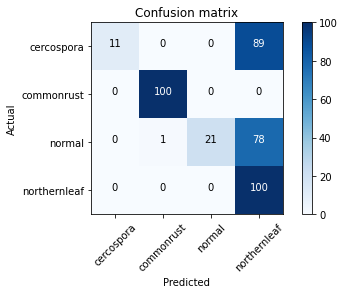

In [33]:
#Evaluasi menggunakan confusion matrix

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

cnf_matrix=confusion_matrix(validation_generator.classes,prediction)
plot_confusion_matrix(cnf_matrix, classes=validation_generator.class_indices)

Model : model_MAIZE_1.h5
Predicted Label : normal
Probability : 0.0



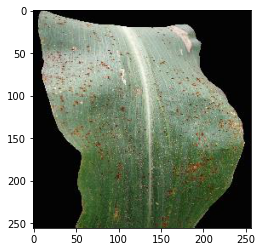

In [34]:
from PIL import Image
from tensorflow.keras.models import load_model
img_upload = Image.open("drive/MyDrive/projek/query/commonrust.jpg")
img_plt = plt.imshow(img_upload)
img = np.array(img_upload)
img = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB)

model_list = ['drive/MyDrive/projek/model/model_MAIZE_1.h5']
labels = ['normal', 'cercospora','commonrust','nothernleaf']

for m in model_list:
    model = load_model(m)
    size_img = model.layers[0].output_shape[1:3]
    imgs = cv2.resize(img, size_img)
    imgs = imgs.astype('float32') / 255
    pred = model.predict(np.expand_dims(imgs, axis=0))[0]
    print('Model :', m.split('/')[-1])
    print('Predicted Label :',labels[((pred > 0.5)+0).ravel()[0]])
    print('Probability :',[ round(elem, 4) for elem in pred ][0])
    print('===============\n')